In [56]:
import pandas as pd
import numpy as np
import datetime as dt
import pickle
from matplotlib import pyplot as plt

## PREPARATION

### Functions

In [57]:
import time
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, precision_score, recall_score, make_scorer
from collections import Counter
from sklearn.neighbors import KDTree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials, space_eval
import xgboost as xgb

In [58]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [59]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    clf = model
    clf.fit(X_train, y_train)
    print_result(clf, X_train, X_test, y_train, y_test)
    return(clf.predict(X_test))

In [60]:
def print_result(clf, X_train, X_test, y_train, y_test):
    print('Accuracy Test :', f'{accuracy_score(clf.predict(X_test), y_test):.4f}', 
          '| F1 Test :', f'{f1_score(clf.predict(X_test), y_test, pos_label="Bad"):.4f}',
          '| Precision Test :', f'{precision_score(clf.predict(X_test), y_test, pos_label="Bad"):.4f}', 
          '| Recall Test :', f'{recall_score(clf.predict(X_test), y_test, pos_label="Bad"):.4f}', 
          '| H Test :', f'{H_score(clf.predict(X_test), y_test):.4f}')
    
    print('Accuracy Train:', f'{accuracy_score(clf.predict(X_train), y_train):.4f}', 
          '| F1 Train:', f'{f1_score(clf.predict(X_train), y_train, pos_label="Bad"):.4f}',
          '| Precision Train:', f'{precision_score(clf.predict(X_train), y_train, pos_label="Bad"):.4f}', 
          '| Recall Train:', f'{recall_score(clf.predict(X_train), y_train, pos_label="Bad"):.4f}', 
          '| H Train:', f'{H_score(clf.predict(X_train), y_train):.4f}')

In [61]:
def H_score(X_train, y_train):
    acc = accuracy_score(X_train, y_train)
    f1 = f1_score(X_train, y_train, pos_label = "Bad")
    return(2 / ((1/(acc+0.00001))+(1/(f1+0.00001))))

In [62]:
def bayesian(space, X, y, modelo, nevals):
    
    f1 = make_scorer(f1_score, pos_label = "Bad")
    H = make_scorer(H_score, greater_is_better=True) 
    
    def objective(space):        
        global best_score
        model = modelo(**space, random_state = 1)   
        cv =  StratifiedKFold(n_splits = 5, random_state = 1)
        score = -cross_val_score(model, X, y, cv = cv, scoring = H, verbose = False).mean()
        if (score < best_score):
            best_score = score
        return score

    start = time.time()
    rstate = np.random.RandomState(1)
    best = fmin(objective, space = space, algo = tpe.suggest, max_evals = nevals,trials = Trials(), rstate = rstate)

    print("Hyperopt search took %.2f seconds" % ((time.time() - start)))
    print("Best score: %.4f " % (-best_score))
    print("Best space: ", space_eval(params, best))
    return(space_eval(params, best))

### Create Data Frame

In [63]:
df_balanced = pd.read_csv('./data/df_balanced.gz')
df_model = df_balanced.sample(n=10000, random_state=1)
df_stacking = df_balanced.drop(df_model.index).sample(n=10000, random_state=11)

In [64]:
x_categorical = ['Review_Month','City','Pet','Purpose','Whom','Room_Recode','Nationality_Recode','Length_Recode','Stars']
x_numerical = ['Average_Score', 'Total_Number_of_Reviews_Reviewer_Has_Given', 'Close_Landmarks', 'Dist_Center', 
               'Dist_Train', 'Dist_Airport','food_Neg_Hotel','staff_Neg_Hotel', 'location_Neg_Hotel', 'value_Neg_Hotel',
               'comfort_Neg_Hotel', 'room_Neg_Hotel', 'facilities_Neg_Hotel','cleanliness_Neg_Hotel', 
               'food_Pos_Hotel', 'staff_Pos_Hotel','location_Pos_Hotel', 'value_Pos_Hotel', 'comfort_Pos_Hotel',
               'room_Pos_Hotel', 'facilities_Pos_Hotel', 'cleanliness_Pos_Hotel','count', 'mean', 'std', 'min', '25%', 
               '50%', '75%', 'max']

x_col = x_categorical + x_numerical
y_col = 'Category'

In [65]:
X_numerical = df_stacking[x_numerical]
X_numerical_std = X_numerical.apply(lambda x: ((x-np.mean(x)) / np.std(x)))

In [66]:
df_stacking['Review_Month'] = df_stacking['Review_Month'].astype(str)
X_categorical = pd.get_dummies(df_stacking[x_categorical], prefix_sep='_', drop_first=False)
X_categorical = X_categorical.fillna('Not Available')

In [67]:
X = pd.concat([X_numerical_std, X_categorical], axis=1, sort=False)
y = df_stacking[y_col]

In [68]:
X = X[['Average_Score', 'Total_Number_of_Reviews_Reviewer_Has_Given', 'mean','std', 'max', 'Review_Month_1', 
       'Review_Month_10', 'Review_Month_2','Review_Month_3', 'Review_Month_4', 'Review_Month_7', 'Review_Month_8',
       'Review_Month_9', 'City_Amsterdam', 'City_London', 'Pet_With a pet','Purpose_Leisure trip', 
       'Whom_Family with older children','Whom_Family with young children', 'Whom_Travelers with friends',
       'Room_Recode_Deluxe', 'Room_Recode_Other (Standard)','Room_Recode_Studio', 'Nationality_Recode_Arab States',
       'Nationality_Recode_Asia & Pacific','Nationality_Recode_Eastern Europe', 'Nationality_Recode_Middle east',
       'Nationality_Recode_North America', 'Nationality_Recode_Oceania','Nationality_Recode_UK & Ireland', 
       'Nationality_Recode_Western Europe','Length_Recode_Stayed 2 nights', 'Length_Recode_Stayed 5 nights',
       'Length_Recode_Stayed 6 nights', 'Length_Recode_Stayed 7 nights','Length_Recode_Stayed 8 nights', 'Stars_Pension',
       'Stars_hotel de 3 estrellas']]

### Add Predictions

In [69]:
models = pickle.load(open('./sav/model_H.sav', 'rb'))

In [70]:
pred_knn = [Counter([y.iloc[k] for k in x]).most_common(1)[0][0] for x in models[0].query(X, k = 114)[1]]
pred_log = models[1].predict(X)
pred_svm = models[2].predict(X)
pred_tree = models[3].predict(X)
pred_rf = models[4].predict(X)
pred_gbt = models[5].predict(X)
pred_xgb = models[6].predict(X)

And I append the predictions of the model to the dataset

In [71]:
X['logistic'] = pred_log
X['gbt'] = pred_gbt
X['knn'] = pred_knn
X['svm'] = pred_svm
X['tree'] = pred_tree
X['xgb'] = pred_xgb
X['rf'] = pred_rf

In [72]:
X.iloc[:,-7:].head(2)

,logistic,gbt,knn,svm,tree,xgb,rf
231987,Bad,Bad,Bad,Bad,Bad,Bad,Bad
178130,Good,Good,Good,Good,Good,Good,Good


In [73]:
X.iloc[:,-7:] = X.iloc[:,-7:].apply(lambda x: [1 if i=='Good' else 0 for i in x])

In [74]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

## MODELS

### Gradient Boosting Trees

In [75]:
params = {'learning_rate':     hp.choice('learning_rate',[0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 
                                                          0.0075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.50, 0.75, 1]), 
          'n_estimators':      hp.choice('n_estimators', range(1,400)),
          'max_depth':         hp.choice('max_depth',range(1,20)),
          'min_samples_split': hp.choice('min_samples_split',np.linspace(0.01, 1.0, 10, endpoint=True)),
          'min_samples_leaf':  hp.choice('min_samples_leaf',np.linspace(0.01, 0.5, 50, endpoint=True)), 
          'subsample':         hp.choice('subsample',[1]), 
          'max_features':      hp.choice('max_features',['sqrt'])}

best_score = 1
gbt_params = bayesian(params, X_train, y_train, GradientBoostingClassifier, 50)
pred_gbt_stck = evaluate_model(GradientBoostingClassifier(**gbt_params), X_train, X_test, y_train, y_test)

100%|████████████████████████████████████████████████| 50/50 [02:01<00:00,  2.43s/trial, best loss: -0.665495226253397]
Hyperopt search took 121.52 seconds
Best score: 0.6655 
Best space:  {'learning_rate': 0.0005, 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 0.17, 'min_samples_split': 0.01, 'n_estimators': 262, 'subsample': 1}
Accuracy Test : 0.6455 | F1 Test : 0.6856 | Precision Test : 0.7593 | Recall Test : 0.6249 | H Test : 0.6650
Accuracy Train: 0.6502 | F1 Train: 0.6862 | Precision Train: 0.7510 | Recall Train: 0.6316 | H Train: 0.6677


### XGBoosting

In [76]:
params = {'learning_rate':    hp.choice('learning_rate',[0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 
                                                         0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75]), 
          'max_depth':        hp.choice('max_depth',range(1,20)),
          'min_child_weight': hp.choice('min_child_weight',np.linspace(0.01, 1.0, 100, endpoint=True)),
          'gamma':            hp.choice('gamma',np.linspace(0.01, 1.0, 100, endpoint=True)), 
          'colsample_bytree': hp.choice('colsample_bytree',np.linspace(0.0, 1, 101, endpoint=True)), 
          'n_estimators':     hp.choice('n_estimators', range(1,200))}

best_score = 1
xgb_params = bayesian(params, X_train, y_train, xgb.XGBClassifier, 50)
pred_xgb_stck = evaluate_model(xgb.XGBClassifier(**xgb_params), X_train, X_test, y_train, y_test)

100%|███████████████████████████████████████████████| 50/50 [08:42<00:00, 10.45s/trial, best loss: -0.6608758617552245]
Hyperopt search took 522.68 seconds
Best score: 0.6609 
Best space:  {'colsample_bytree': 0.64, 'gamma': 0.79, 'learning_rate': 0.005, 'max_depth': 3, 'min_child_weight': 0.51, 'n_estimators': 132}
Accuracy Test : 0.6600 | F1 Test : 0.6813 | Precision Test : 0.7141 | Recall Test : 0.6514 | H Test : 0.6705
Accuracy Train: 0.6548 | F1 Train: 0.6720 | Precision Train: 0.6948 | Recall Train: 0.6507 | H Train: 0.6633


### SVM

In [77]:
params = {"degree": hp.choice('degree', [2, 3, 4]),
          "kernel": hp.choice('kernel', ['poly']), 
          "C":      hp.choice('C', [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 
                                    0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75])}
best_score = 1
svm_params = bayesian(params, X_train, y_train, SVC, 10)
pred_svm_stck = evaluate_model(SVC(**svm_params), X_train, X_test, y_train, y_test)

100%|███████████████████████████████████████████████| 10/10 [04:11<00:00, 25.19s/trial, best loss: -0.6684343261064386]
Hyperopt search took 251.92 seconds
Best score: 0.6684 
Best space:  {'C': 0.075, 'degree': 3, 'kernel': 'poly'}
Accuracy Test : 0.6530 | F1 Test : 0.6865 | Precision Test : 0.7466 | Recall Test : 0.6355 | H Test : 0.6694
Accuracy Train: 0.6565 | F1 Train: 0.6860 | Precision Train: 0.7370 | Recall Train: 0.6416 | H Train: 0.6709


### Logistic Regression

In [78]:
params = {"C":   hp.choice('C',[0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005, 0.01, 0.025, 0.05, 0.1]),
          ""
          "tol": hp.choice('tol',[0.00001, 0.000025, 0.00005, 0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005, 0.01, 0.025, 
                                  0.05, 0.1])}

best_score = 1
log_params = bayesian(params, X_train, y_train, LogisticRegression, 50)
pred_log_stck = evaluate_model(LogisticRegression(**log_params), X_train, X_test, y_train, y_test)

100%|███████████████████████████████████████████████| 50/50 [00:28<00:00,  1.78trial/s, best loss: -0.6582675861708193]
Hyperopt search took 28.11 seconds
Best score: 0.6583 
Best space:  {'C': 0.01, 'tol': 0.005}
Accuracy Test : 0.6560 | F1 Test : 0.6705 | Precision Test : 0.6876 | Recall Test : 0.6542 | H Test : 0.6632
Accuracy Train: 0.6567 | F1 Train: 0.6663 | Precision Train: 0.6730 | Recall Train: 0.6597 | H Train: 0.6615


### Random Forest

In [79]:
params = {'bootstrap':         hp.choice('bootstrap',[True, False]),
          'max_depth':         hp.choice('max_depth', range(1, 20)),
          'max_features':      hp.choice('max_features',['auto', 'sqrt']),
          'min_samples_leaf':  hp.choice('min_samples_leaf',np.linspace(0.01, 0.5, 50, endpoint=True)), 
          'min_samples_split': hp.choice('min_samples_split',np.linspace(0.01, 1.0, 100, endpoint=True)), 
          'n_estimators':      hp.choice('n_estimators',range(1,400))}

best_score = 1
rf_params = bayesian(params, X_train, y_train, RandomForestClassifier, 50)
pred_rf_stck = evaluate_model(RandomForestClassifier(**rf_params), X_train, X_test, y_train, y_test)

100%|███████████████████████████████████████████████| 50/50 [03:11<00:00,  3.84s/trial, best loss: -0.6553343763245401]
Hyperopt search took 191.94 seconds
Best score: 0.6553 
Best space:  {'bootstrap': False, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 0.05, 'min_samples_split': 0.29000000000000004, 'n_estimators': 13}
Accuracy Test : 0.6555 | F1 Test : 0.6730 | Precision Test : 0.6965 | Recall Test : 0.6511 | H Test : 0.6641
Accuracy Train: 0.6489 | F1 Train: 0.6613 | Precision Train: 0.6732 | Recall Train: 0.6498 | H Train: 0.6550


### Best Models

In [253]:
svm_params =  {'C': 0.00025, 'degree': 4, 'kernel': 'poly'}
pred_svm_stck = evaluate_model(SVC(**svm_params), X_train_2, X_test_2, y_train_2, y_test_2)

Accuracy Test : 0.6115 | F1 Test : 0.7051 | Precision Test : 0.9171 | Recall Test : 0.5727 | H Test : 0.6550
Accuracy Train: 0.6050 | F1 Train: 0.6955 | Precision Train: 0.9056 | Recall Train: 0.5645 | H Train: 0.6471


In [254]:
pd.crosstab(pred_svm_stck, y_test_2)

Category,Bad,Good
row_0,,
Bad,929,693
Good,84,294


In [255]:
xgb_params = {'colsample_bytree': 0.98, 'gamma': 0.17, 'learning_rate': 0.0001, 'max_depth': 1, 
              'min_child_weight': 0.060000000000000005, 'n_estimators': 189}
pred_xgb_stck = evaluate_model(xgb.XGBClassifier(**xgb_params), X_train_2, X_test_2, y_train_2, y_test_2)

Accuracy Test : 0.6600 | F1 Test : 0.6959 | Precision Test : 0.7680 | Recall Test : 0.6361 | H Test : 0.6775
Accuracy Train: 0.6539 | F1 Train: 0.6895 | Precision Train: 0.7714 | Recall Train: 0.6233 | H Train: 0.6712


In [256]:
pd.crosstab(pred_xgb_stck, y_test_2)

Category,Bad,Good
row_0,,
Bad,778,445
Good,235,542


## CONFIDENCE INTERVAL

In [258]:
pred_ac, pred_pr, pred_rc = [], [], []

clf = xgb.XGBClassifier(**xgb_params)
clf.fit(X_train, y_train)

np.random.seed(1)
for i in range(1000):
    sample = np.random.randint(0, len(X_test), size=len(X_test))
    X_sample = X_test.iloc[sample]
    y_sample = y_test.iloc[sample]
    print(i, end='\r', flush=True)
    pred_ac.append(accuracy_score(clf.predict(X_sample), y_sample))
    pred_rc.append(recall_score(clf.predict(X_sample), y_sample, pos_label="Bad"))
    pred_pr.append(precision_score(clf.predict(X_sample), y_sample, pos_label="Bad"))

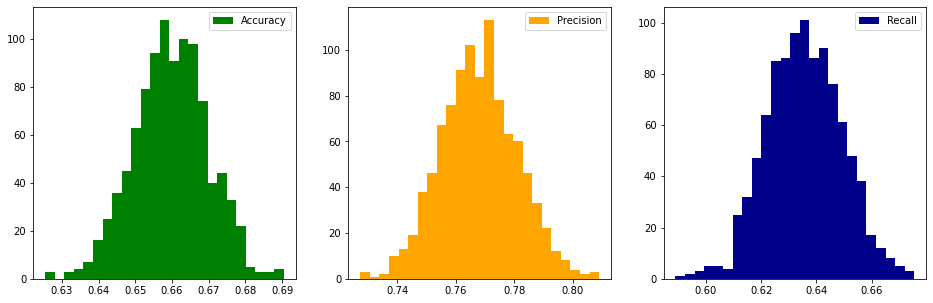

In [281]:
fig, ax=plt.subplots(1, 3, figsize=(16, 5))
ax[0].hist(pred_ac, bins=25, label='Accuracy', color='green')
ax[1].hist(pred_pr, bins=25, label='Precision', color='orange')
ax[2].hist(pred_rc, bins=25, label='Recall', color="darkblue")
ax[0].legend()
ax[1].legend()
ax[2].legend()

In [260]:
print('             0.5%    50%  99.5%')
print('Accuracy :',f'{np.percentile(pred_ac,0.5):.4f}',f'{np.percentile(pred_ac,50):.4f}',f'{np.percentile(pred_ac,99.5):.4f}')
print('Precision:',f'{np.percentile(pred_pr,0.5):.4f}',f'{np.percentile(pred_pr,50):.4f}',f'{np.percentile(pred_pr,99.5):.4f}')
print('Recall   :',f'{np.percentile(pred_rc,0.5):.4f}',f'{np.percentile(pred_rc,50):.4f}',f'{np.percentile(pred_rc,99.5):.4f}')

             0.5%    50%  99.5%
Accuracy : 0.6330 0.6595 0.6860
Precision: 0.7362 0.7677 0.8014
Recall   : 0.5985 0.6353 0.6708
